In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset, Dataset

In [6]:
spans = load_dataset(
    'RicardoRei/wmt-mqm-error-spans',
    split='train'
).to_pandas()
mqm = load_dataset(
    'RicardoRei/wmt-mqm-human-evaluation',
    split='train'
).to_pandas()

Generating train split: 150347 examples [00:00, 184694.90 examples/s]


In [2]:
# https://huggingface.co/datasets/RicardoRei/wmt-mqm-error-spans
spans = pd.read_json(path_or_buf="data/train.jsonl", lines=True)

# https://huggingface.co/datasets/RicardoRei/wmt-mqm-human-evaluation
mqm = pd.read_csv("data/wmt-mqm-human-evaluation.csv")

## Looking around

In [7]:
spans.columns

Index(['src', 'mt', 'ref', 'annotations', 'lp'], dtype='object')

In [8]:
mqm.columns

Index(['lp', 'src', 'mt', 'ref', 'score', 'system', 'annotators', 'domain',
       'year'],
      dtype='object')

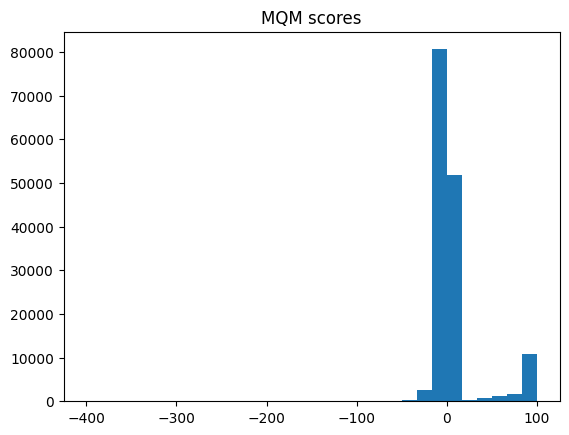

In [9]:
plt.title("MQM scores")
plt.hist(mqm.score, bins=30,)
plt.show()

In [6]:
len(spans), len(mqm)

(167360, 150347)

In [10]:
spans.drop(columns=["annotations"]).nunique()

src     10115
mt     131823
ref     12271
lp          3
dtype: int64

In [11]:
mqm.nunique()

lp                 3
src             8933
mt            118092
ref            16076
score            967
system            62
annotators         2
domain             5
year               3
dtype: int64

In [12]:
text = ["src", "mt", "ref"]

concat = pd.concat([spans[text], mqm[text]], axis=0)
concat.nunique()

src     10774
mt     144080
ref     18039
dtype: int64

In [13]:
translations_counts = spans["mt"].value_counts()

In [14]:
translations_counts[translations_counts > 1]

mt
Tippen Sie auf Einstellungen.                                                                                                                                                                                                                                                                    117
Перейдите на главный экран.                                                                                                                                                                                                                                                                      116
Tippen Sie auf Geräteinformationen.                                                                                                                                                                                                                                                               96
Gehen Sie zu Ihrem Startbildschirm.                                                                                   

In [15]:
popular_translation = translations_counts[translations_counts > 1].index[0]
popular_translation

'Tippen Sie auf Einstellungen.'

In [16]:
spans[spans["mt"] == popular_translation]

,src,mt,ref,annotations,lp
81,Tap Settings.,Tippen Sie auf Einstellungen.,Tippen Sie auf „Einstellungen“.,"[{'start': 15, 'end': 27, 'severity': 'minor',...",en-de
87,Tap Settings.,Tippen Sie auf Einstellungen.,Tippen Sie auf „Einstellungen“.,[],en-de
122,Tap Settings.,Tippen Sie auf Einstellungen.,Tippen Sie auf „Einstellungen“.,[],en-de
167,Tap Settings.,Tippen Sie auf Einstellungen.,Tippen Sie auf „Einstellungen“.,[],en-de
185,Tap Settings.,Tippen Sie auf Einstellungen.,Tippen Sie auf „Einstellungen“.,"[{'start': 15, 'end': 27, 'severity': 'minor',...",en-de
...,...,...,...,...,...
5983,Tap Settings.,Tippen Sie auf Einstellungen.,Tippen Sie auf „Einstellungen“.,[],en-de
6066,Tap Settings.,Tippen Sie auf Einstellungen.,Tippen Sie auf „Einstellungen“.,[],en-de
6099,Tap Settings.,Tippen Sie auf Einstellungen.,Tippen Sie auf „Einstellungen“.,[],en-de
6110,Tap Settings.,Tippen Sie auf Einstellungen.,Tippen Sie auf „Einstellungen“.,[],en-de


In [14]:
spans.loc[spans["mt"] == popular_translation, "annotations"].iloc[0]

[{'start': 15, 'end': 27, 'severity': 'minor', 'text': 'Einstellunge'}]

In [17]:
mqm_translations_counts = mqm["mt"].value_counts()

In [18]:
mqm_translations_counts

mt
Tippen Sie auf Einstellungen.                                                                                                                                                                                                                                                                                                                 117
Перейдите на главный экран.                                                                                                                                                                                                                                                                                                                   110
Tippen Sie auf Geräteinformationen.                                                                                                                                                                                                                                                                                              

## Filter out "news" 2020:

In [19]:
test = mqm[(mqm["domain"] == "news") & (mqm["year"] == 2022)]

In [20]:
len(test)

16575

In [21]:
test.lp.value_counts()

lp
zh-en    7575
en-de    4500
en-ru    4500
Name: count, dtype: int64

In [22]:
def filter_out_test(data, test, column_set):
    filtered = data.copy()

    for col in column_set:
        black_list = set(test[col].unique())
        filtered = filtered[~filtered[col].isin(black_list)]

    return filtered

In [23]:
column_set = ["src", "mt", "ref"]
filtered = filter_out_test(spans, test, column_set)

In [24]:
for col in column_set:
    assert len(np.intersect1d(filtered[col].unique(), test[col].unique())) == 0, col

In [25]:
len(filtered)

150485

In [26]:
len(spans) - len(test)

150785

## Try to add domain and year data to train

Ensure that for each source sentence the year and domain data is consistent:

In [27]:
mqm.groupby("src")["year"].nunique().mean()

1.0

In [28]:
mqm.groupby("src")["domain"].nunique().mean()

1.0

For each unique source sentence keep it's year and domain:

In [29]:
unique_src = mqm.drop_duplicates("src")[["src", "year", "domain"]]
unique_src.head()

,src,year,domain
0,Michael Jackson wore tape on his nose to get f...,2020,news
1,Michael Jackson's former bodyguard has claimed...,2020,news
2,"Matt Fiddes, now a property developer and owne...",2020,news
3,"To get front pages, he would reportedly don su...",2020,news
4,We'll tell you what's true. You can form your ...,2020,news


In [30]:
extended_filtered = filtered.merge(unique_src, on="src", how="left", suffixes=["_spans", "_mqm"])

In [31]:
len(extended_filtered), len(filtered)

(150485, 150485)

In [32]:
extended_filtered["domain"].isna().mean(), extended_filtered["year"].isna().mean()

(0.024673555503870816, 0.024673555503870816)

Apparently, some source sentences in dataset with spans are new. For them let's mark year and domain as unknown.

In [33]:
extended_filtered = extended_filtered.fillna("__unknown__")

Let's add MQM score column, computing MQM as described in xCOMET [paper](https://arxiv.org/pdf/2310.10482.pdf) (section 4.2.2).

In [34]:
severity_to_weight = {
    "minor": 1,
    "major": 5,
    "critical": 10,
}

def annotation_to_score(sample):
    annot = sample["annotations"]

    score = 0
    for error in annot:
        score += severity_to_weight[error["severity"]]

    return (25 - score) / 25 if score < 25 else 0

In [35]:
extended_filtered["score"] = extended_filtered.apply(annotation_to_score, axis=1)

### Examples

In [36]:
extended_filtered.sample(6, random_state=1)

,src,mt,ref,annotations,lp,year,domain,score
31892,"However, the star's family reality show Keepin...",Allerdings zeigte die Familien-Reality-Show de...,"Jedoch war in der Reality Show der Familie, „K...","[{'start': 22, 'end': 53, 'severity': 'minor',...",en-de,2020.0,news,0.96
19450,"I am not talking about perfect equality, I'm t...","Ich spreche nicht von perfekter Gleichheit, ic...","Ich meine nicht perfekte Gleichheit, ich sprec...","[{'start': 72, 'end': 78, 'severity': 'minor',...",en-de,2021.0,ted,0.92
90047,周漪婷同学则说，如何挖掘品牌文化，让优质的传统文化代代传承、生生不息，是我们作为设计专业学生...,Student Zhou Yiting said that how to tap into ...,Student Zhou Yiting says that as a student mas...,"[{'start': 0, 'end': 12, 'severity': 'major', ...",zh-en,2020.0,news,0.80
135920,"For the second consecutive time, Mr Patrick Af...",Главный руководитель управления цепями поставк...,Главный руководитель управления цепями поставк...,[],en-ru,__unknown__,__unknown__,1.00
81920,"互动知识分享节目《叮咚上线!老师好》,将于7月20日起在湖南卫视播出。","Interactive knowledge sharing program ""Ding Do...",Interactive knowledge sharing program “Ding Do...,"[{'start': 39, 'end': 55, 'severity': 'major',...",zh-en,2021.0,news,0.60
93239,大鹏导演《吉祥如意》入围金爵奖-新华网,"Director Dapeng's ""Auspicious Ruyi"" shortliste...",The Reunions directed by Dapeng was shortliste...,"[{'start': 18, 'end': 35, 'severity': 'minor',...",zh-en,2021.0,news,0.76


### Subsets by year and domain

In [37]:
extended_filtered.groupby(["year", "domain"]).size()

year         domain      
2020.0       news            43202
2021.0       news            26603
             ted             24952
2022.0       conversation    19030
             ecommerce       14900
             social          18085
__unknown__  __unknown__      3713
dtype: int64

It sounds reasonable to e.g. use `social 2022` as a validation subset during experiments.

### Examples of errors

In [38]:
non_zero_errors = extended_filtered[extended_filtered["annotations"].str.len() > 0]
len(non_zero_errors)

90246

In [39]:
non_zero_errors.sample(n=1, random_state=222).values

array([["This one's clever. It's called obsidian.",
        'Dieser ist clever. Es heißt Obsidian.',
        'Diese hier ist clever. Sie heißt Obsidium.',
        array([{'start': 0, 'end': 6, 'severity': 'minor', 'text': 'Dieser'},
               {'start': 19, 'end': 21, 'severity': 'minor', 'text': 'Es'}],
              dtype=object)                                                  ,
        'en-de', 2021.0, 'ted', 0.92]], dtype=object)

In [40]:
non_zero_errors.sample(n=1, random_state=338).values

array([['UC Davis professor Geoff Schladow said it\'s an "important indicator of how healthy the lake is."',
        'Geoff Schladow, Professor an der Universität im kalifornischen Davis, sagt: „Es handelt sich um einen wichtigen Hinweis zum Gesundheitszustand des Sees.“',
        'Professor Geoff Schladow der UC Davis sagte, es sei „ein wichtiger Indikator für die Gesundheit des Sees.“',
        array([{'start': 124, 'end': 142, 'severity': 'minor', 'text': 'Gesundheitszustand'}],
              dtype=object)                                                                   ,
        'en-de', 2021.0, 'news', 0.96]], dtype=object)

### Fractions of sentences by worst error

In [41]:
def worst_error(error_spans):
    error2rank = {
        "minor": 1,
        "major": 2,
        "critical": 3,
    }
    rank2error = dict(zip([0, 1, 2, 3], ["none", "minor", "major", "critical"]))

    ranks = [error2rank[span["severity"]] for span in error_spans]

    max_rank = 0 if not ranks else max(ranks)

    return rank2error[max_rank] 

In [42]:
extended_filtered["annotations"].apply(lambda x: worst_error(x)).value_counts()

annotations
none        60239
major       48363
minor       41110
critical      773
Name: count, dtype: int64

In [43]:
val_mask = (extended_filtered["year"] == 2022) & (extended_filtered["domain"] == "social")

val_error_counts = extended_filtered.loc[val_mask, "annotations"].apply(lambda x: worst_error(x)).value_counts()
train_error_counts = extended_filtered.loc[~val_mask, "annotations"].apply(lambda x: worst_error(x)).value_counts()

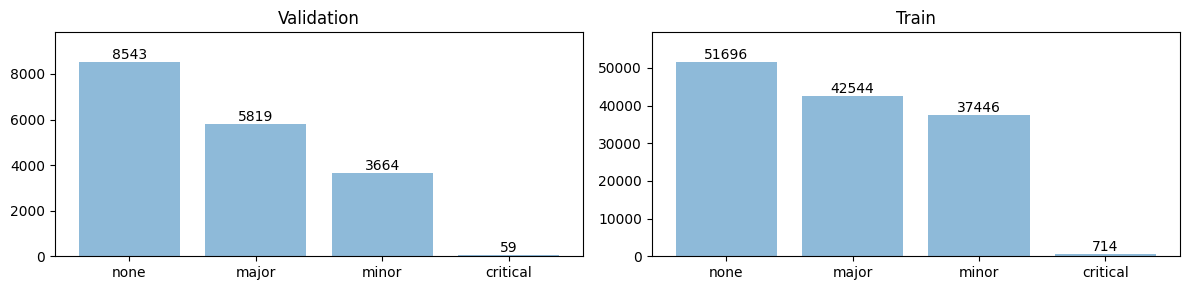

In [44]:
plt.figure(figsize=(12, 3))
plt.subplot(1,2,1)
container = plt.bar(val_error_counts.index, val_error_counts.values, alpha=0.5)
plt.bar_label(container, val_error_counts.values)
plt.ylim(top=val_error_counts.max() * 1.15)
plt.title("Validation")

plt.subplot(1,2,2)
container = plt.bar(train_error_counts.index, train_error_counts.values, alpha=0.5)
plt.bar_label(container, train_error_counts.values)
plt.ylim(top=train_error_counts.max() * 1.15)
plt.title("Train")

plt.tight_layout()
plt.show()

### Search for invalid entries

In [45]:
# reference of problematic sample
ref = "In picture 9, the peak of the heat wave of one event happens to be the trough of another event, and the time is exactly the same; it must be because a unified batch of paid internet trolls have received the task and started a new round of offensive."

In [46]:
extended_filtered[extended_filtered["ref"] == ref]

,src,mt,ref,annotations,lp,year,domain,score
65408,图9中，一个事件的热度波峰恰好是另一事件的波谷，时间分秒不差，必定是统一批水军接到任务，开启...,"In Figure 9, the heat peak of one event happen...","In picture 9, the peak of the heat wave of one...","[{'start': 99, 'end': 105, 'severity': 'major'...",zh-en,2022.0,social,0.60
65911,图9中，一个事件的热度波峰恰好是另一事件的波谷，时间分秒不差，必定是统一批水军接到任务，开启...,"In Figure 9, the peak of the heat wave of one ...","In picture 9, the peak of the heat wave of one...","[{'start': 100, 'end': 112, 'severity': 'major...",zh-en,2022.0,social,0.60
66414,图9中，一个事件的热度波峰恰好是另一事件的波谷，时间分秒不差，必定是统一批水军接到任务，开启...,"In figure 9, the heat wave peak of one event h...","In picture 9, the peak of the heat wave of one...","[{'start': 104, 'end': 110, 'severity': 'major...",zh-en,2022.0,social,0.60
66917,图9中，一个事件的热度波峰恰好是另一事件的波谷，时间分秒不差，必定是统一批水军接到任务，开启...,"In Figure 9, the heat peak of one event happen...","In picture 9, the peak of the heat wave of one...","[{'start': 99, 'end': 121, 'severity': 'major'...",zh-en,2022.0,social,0.80
67420,图9中，一个事件的热度波峰恰好是另一事件的波谷，时间分秒不差，必定是统一批水军接到任务，开启...,"In Figure 9, the heat peak of one event happen...","In picture 9, the peak of the heat wave of one...","[{'start': 99, 'end': 105, 'severity': 'major'...",zh-en,2022.0,social,0.60
67923,图9中，一个事件的热度波峰恰好是另一事件的波谷，时间分秒不差，必定是统一批水军接到任务，开启...,"In Figure 9, the heat wave of one event is exa...","In picture 9, the peak of the heat wave of one...","[{'start': 92, 'end': 98, 'severity': 'major',...",zh-en,2022.0,social,0.56
68426,图9中，一个事件的热度波峰恰好是另一事件的波谷，时间分秒不差，必定是统一批水军接到任务，开启...,"In Figure 9, the peak of the heat of one event...","In picture 9, the peak of the heat wave of one...","[{'start': 106, 'end': 112, 'severity': 'major...",zh-en,2022.0,social,0.60
68929,图9中，一个事件的热度波峰恰好是另一事件的波谷，时间分秒不差，必定是统一批水军接到任务，开启...,"In Figure 9, the peak of the popularity of one...","In picture 9, the peak of the heat wave of one...","[{'start': 109, 'end': 115, 'severity': 'major...",zh-en,2022.0,social,0.60
69432,图9中，一个事件的热度波峰恰好是另一事件的波谷，时间分秒不差，必定是统一批水军接到任务，开启...,"In Figure 9, the peak of the heat of one event...","In picture 9, the peak of the heat wave of one...","[{'start': 102, 'end': 108, 'severity': 'major...",zh-en,2022.0,social,0.60
69935,图9中，一个事件的热度波峰恰好是另一事件的波谷，时间分秒不差，必定是统一批水军接到任务，开启...,nan,"In picture 9, the peak of the heat wave of one...",[],zh-en,2022.0,social,1.00


In [47]:
(extended_filtered["mt"] == "nan").sum()

1

In [48]:
extended_filtered = extended_filtered[extended_filtered["mt"] != "nan"]
(extended_filtered["mt"] == "nan").mean()

0.0

### Store dataset

In [50]:
extended_filtered.to_csv("data/mqm-spans-with-year-and-domain-but-no-news-2022.csv", index=False)